In [1]:
from pandas_ods_reader import read_ods
import dlib
import matplotlib.pyplot as plt
import os, glob, cv2, random
import seaborn as sns
import pandas as pd
import numpy as np
import csv
import datetime
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from playsound import playsound

In [2]:
def salt_noise(img): 
    row , col = img.shape

    # Randomly pick some pixels in the
    # image for coloring them white
    for i in range(1000):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        img[y_coord][x_coord] = 255
        y_coord=random.randint(0, row - 1)
        x_coord=random.randint(0, col - 1)
        img[y_coord][x_coord] = 0
    return img

In [3]:
def read_csv(path):
    width = 34
    height = 26
    dims = 1
    with open(path,'r') as f:
        reader = csv.DictReader(f)
        rows = list(reader)
    row_len = len(list(rows)) * 8
    imgs = np.empty((row_len, height, width, dims),dtype=np.uint8)
    tags = np.empty((row_len, 1))
    
    #creating noise overlay
    noise = np.zeros((26, 34),dtype=np.uint8)
    salt = (salt_noise(noise) * 0.3).astype(np.uint8)
    cv2.randu(noise, 0, 255)
    uniform_noise = (noise * 0.2).astype(np.uint8)
    i = 0
    for row in rows:
        #the tag for open is 1 and for close is 0
        tag = 0
        if row['state'] == 'open':
            tag = 1
        else:
            tag = 0
        im = row['image']
        im = im.strip('[').strip(']').split(', ')
        img = np.array(im, dtype=np.uint8)
        
        #Applying image augmentation to increase the dataset and variations in the data
        img = img.reshape((height, width))
        img1 = cv2.flip(img, 1)
        img2 = cv2.add(img, uniform_noise)
        img3 = cv2.add(img1, uniform_noise)
        img4 = cv2.blur(img, (9,9))
        img5 = cv2.blur(img1, (9,9)) 
        img6 = cv2.add(img, salt)
        img7 = cv2.add(img1, salt)
        #img8 = cv2.medianBlur(img6, 9)
        #img9 = cv2.medianBlur(img7, 9)
        
        img = np.expand_dims(img, axis=2)
        imgs[i] = img
        tags[i] = tag
        i = i + 1
        img1 = np.expand_dims(img1, axis=2)
        imgs[i] = img1
        tags[i] = tag
        i = i + 1
        img2 = np.expand_dims(img2, axis=2)
        imgs[i] = img2
        tags[i] = tag
        i = i + 1
        img3 = np.expand_dims(img3, axis=2)
        imgs[i] = img3
        tags[i] = tag
        i = i + 1
        img4 = np.expand_dims(img4, axis=2)
        imgs[i] = img4
        tags[i] = tag
        i = i + 1
        img5 = np.expand_dims(img5, axis=2)
        imgs[i] = img5
        tags[i] = tag
        i = i + 1
        img6 = np.expand_dims(img6, axis=2)
        imgs[i] = img6
        tags[i] = tag
        i = i + 1
        img7 = np.expand_dims(img7, axis=2)
        imgs[i] = img7
        tags[i] = tag
        i = i + 1

    #shuffle the dataset
    index = np.random.permutation(imgs.shape[0])
    imgs = imgs[index]
    tags = tags[index]
    
    return imgs, tags

In [4]:
base_path = 'dataset'

X, y = read_csv(os.path.join(base_path, 'dataset.csv'))

print(X.shape, y.shape)

(22992, 26, 34, 1) (22992, 1)


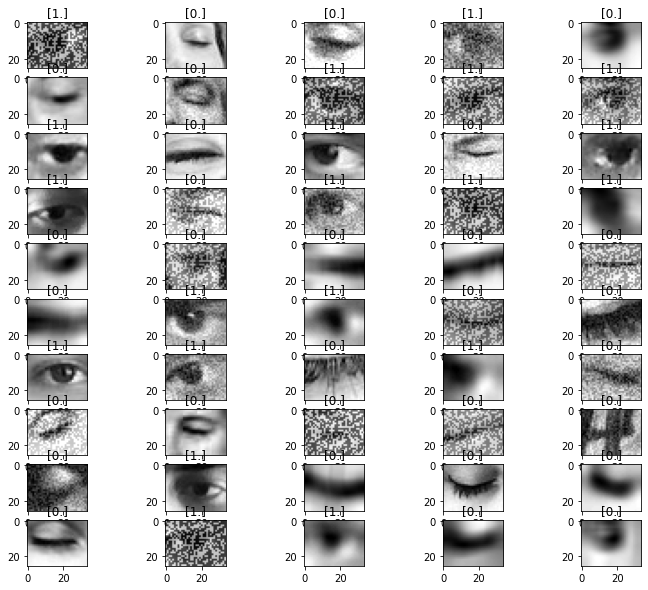

In [6]:
plt.figure(figsize=(12, 10))
for i in range(50):
    plt.subplot(10, 5, i+1)
    plt.axis('on')
    plt.title(y[i])
    plt.imshow(X[i].reshape((26, 34)), cmap='gray')

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

np.save('dataset/x_train.npy', x_train)
np.save('dataset/y_train.npy', y_train)
np.save('dataset/x_val.npy', x_val)
np.save('dataset/y_val.npy', y_val)

(18393, 26, 34, 1) (18393, 1)
(4599, 26, 34, 1) (4599, 1)


In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

In [9]:
inputs = Input(shape=(26, 34, 1))

net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(512)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 26, 34, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 34, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 17, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 4, 128)         0     

In [239]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit_generator(
    train_generator, epochs=50, validation_data=val_generator,
    callbacks=[
        ModelCheckpoint('models/%s.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

Epoch 1/50
575/575 [==============================] - 15s 26ms/step - loss: 0.4028 - acc: 0.8090 - val_loss: 0.1316 - val_acc: 0.9528

Epoch 00001: val_acc improved from -inf to 0.95282, saving model to models/2021_05_05_14_56_31.h5
Epoch 2/50
575/575 [==============================] - 15s 26ms/step - loss: 0.1513 - acc: 0.9452 - val_loss: 0.0880 - val_acc: 0.9713

Epoch 00002: val_acc improved from 0.95282 to 0.97130, saving model to models/2021_05_05_14_56_31.h5
Epoch 3/50
575/575 [==============================] - 15s 26ms/step - loss: 0.1177 - acc: 0.9579 - val_loss: 0.0855 - val_acc: 0.9709

Epoch 00003: val_acc did not improve from 0.97130
Epoch 4/50
575/575 [==============================] - 18s 31ms/step - loss: 0.0904 - acc: 0.9663 - val_loss: 0.0802 - val_acc: 0.9724

Epoch 00004: val_acc improved from 0.97130 to 0.97239, saving model to models/2021_05_05_14_56_31.h5
Epoch 5/50
575/575 [==============================] - 19s 33ms/step - loss: 0.0809 - acc: 0.9714 - val_loss: 0

test acc: 0.9963035442487497


<AxesSubplot:>

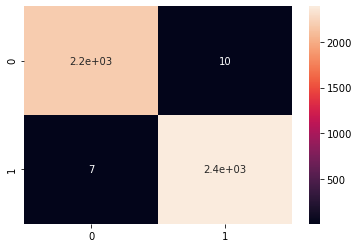

In [10]:

from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

model = load_model('models/2021_05_05_14_56_31.h5')

y_pred = model.predict(x_val/255.)
y_pred_logical = (y_pred > 0.5).astype(np.int)

print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True)

In [11]:
def crop_eye(img, eye_points):
    x1, y1 = np.amin(eye_points, axis=0)
    x2, y2 = np.amax(eye_points, axis=0)
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2

    w = (x2 - x1) * 1.2
    h = w * IMG_SIZE[1] / IMG_SIZE[0]

    margin_x, margin_y = w / 2, h / 2

    min_x, min_y = int(cx - margin_x), int(cy - margin_y)
    max_x, max_y = int(cx + margin_x), int(cy + margin_y)

    eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(np.int)

    eye_img = gray[eye_rect[1]:eye_rect[3], eye_rect[0]:eye_rect[2]]

    return eye_img, eye_rect

In [14]:
from imutils import face_utils
from keras.models import load_model

IMG_SIZE = (34, 26)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('predictor.dat')

model = load_model('models/2021_05_05_14_56_31.h5')
model.summary()

# main
vid = cv2.VideoCapture(0)

wcount = 0
bcount = 0
dcount = 0
blinks = 0
winks = 0
drowsy = ""
sound = input("Audio file name:")
while True:
    ret, img_ori = vid.read()

    if not ret:
        break

    img_ori = cv2.resize(img_ori, dsize=(0, 0), fx=0.5, fy=0.5)

    img = img_ori.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = detector(gray)
    
    for face in faces:
        shapes = predictor(gray, face)
        shapes = face_utils.shape_to_np(shapes)

        eye_img_l, eye_rect_l = crop_eye(gray, eye_points=shapes[36:42])
        eye_img_r, eye_rect_r = crop_eye(gray, eye_points=shapes[42:48])

        eye_img_l = cv2.resize(eye_img_l, dsize=IMG_SIZE)
        eye_img_r = cv2.resize(eye_img_r, dsize=IMG_SIZE)
        eye_img_r = cv2.flip(eye_img_r, flipCode=1)

        cv2.imshow('l', eye_img_l)
        cv2.imshow('r', eye_img_r)

        eye_input_l = eye_img_l.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.
        eye_input_r = eye_img_r.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.

        pred_l = model.predict(eye_input_l)
        pred_r = model.predict(eye_input_r)
        
        
        if(pred_l < 0.1 and pred_r > 0.1) or (pred_r < 0.1 and pred_l > 0.1):
            bcount = 0
            wcount += 1
        elif(pred_l < 0.1 and pred_r < 0.1):
            wcount = 0
            bcount += 1
        elif(wcount >= 3):
            winks += 1
            wcount = 0
        elif(bcount >= 2):
            blinks += 1
            bcount = 0
        if(pred_l + pred_r <= 0.3):
            dcount += 1
            if(dcount > 30):
                playsound(sound)
                drowsy = "Wake Up Bruh"
        else:
            drowsy = ""
            dcount = 0

        # visualize
        state_l = 'O %.1f' if pred_l > 0.1 else '- %.1f'
        state_r = 'O %.1f' if pred_r > 0.1 else '- %.1f'

        state_l = state_l % pred_l
        state_r = state_r % pred_r

        cv2.rectangle(img, pt1=tuple(eye_rect_l[0:2]), pt2=tuple(eye_rect_l[2:4]), color=(255,255,255), thickness=1)
        cv2.rectangle(img, pt1=tuple(eye_rect_r[0:2]), pt2=tuple(eye_rect_r[2:4]), color=(255,255,255), thickness=1)

        cv2.putText(img, state_l, tuple(eye_rect_l[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 1)
        cv2.putText(img, state_r, tuple(eye_rect_r[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 1)
        cv2.putText(img, "Blinks: {}".format(blinks), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(img, "Winks: {}".format(winks), (450, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(img, "{}".format(drowsy), (200, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    cv2.imshow('result', img)
    if cv2.waitKey(1) == ord('q'):
        vid.release()
        cv2.destroyAllWindows()
        break

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 26, 34, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 34, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 17, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 4, 128)         0   